In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(64, 64, 1))  

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


In [2]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
__________

In [3]:
import numpy as np
x_train=np.loadtxt('train_64.csv',delimiter='\t')

x_test=np.loadtxt('test_64.csv',delimiter='\t')
print(x_train.shape)
print(x_test.shape)

(10000, 4096)
(1000, 4096)


(45, 45, 1)


In [4]:
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))  
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))  

In [23]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5)

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopping])

Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 192s 19ms/step - loss: 0.0893 - val_loss: 0.0941
Epoch 2/50
10000/10000 [==============================] - 193s 19ms/step - loss: 0.0890 - val_loss: 0.0998
Epoch 3/50
10000/10000 [==============================] - 189s 19ms/step - loss: 0.0888 - val_loss: 0.1012
Epoch 4/50
10000/10000 [==============================] - 190s 19ms/step - loss: 0.0888 - val_loss: 0.1052
Epoch 5/50
10000/10000 [==============================] - 191s 19ms/step - loss: 0.0886 - val_loss: 0.0983
Epoch 6/50
10000/10000 [==============================] - 190s 19ms/step - loss: 0.0889 - val_loss: 0.0958
Epoch 7/50
10000/10000 [==============================] - 192s 19ms/step - loss: 0.0883 - val_loss: 0.0919
Epoch 8/50
10000/10000 [==============================] - 193s 19ms/step - loss: 0.0879 - val_loss: 0.0951
Epoch 9/50
10000/10000 [==============================] - 190s 19ms/step - loss: 0.0878 - val_l

KeyboardInterrupt: 

In [ ]:

autoencoder.save('autoencoder_model.h5')  # creates a HDF5 file 'my_model.h5'
#del autoencoder  # deletes the existing model

In [ ]:
#loading saved model
from keras.models import load_model
autoencoder = load_model('autoencoder_model.h5')

In [37]:
from keras.models import Sequential

encoder_model = Sequential()
for layer in autoencoder.layers[0:9]:
    encoder_model.add(layer)


In [38]:
encoded_imgs = encoder_model.predict(x_train)
encoded_imgs.shape

(10000, 4, 4, 16)

In [54]:
compressed_imgs=encoded_imgs.reshape(10000,256)
compressed_imgs.shape

(10000, 256)

In [57]:
np.savetxt("compressed_256.csv", compressed_imgs, delimiter="\t")

In [39]:

decoder_model = Sequential()
for layer in autoencoder.layers[9:17]:
    decoder_model.add(layer)

In [40]:
decoded_imgs = decoder_model.predict(encoded_imgs)
decoded_imgs.shape

(10000, 64, 64, 1)

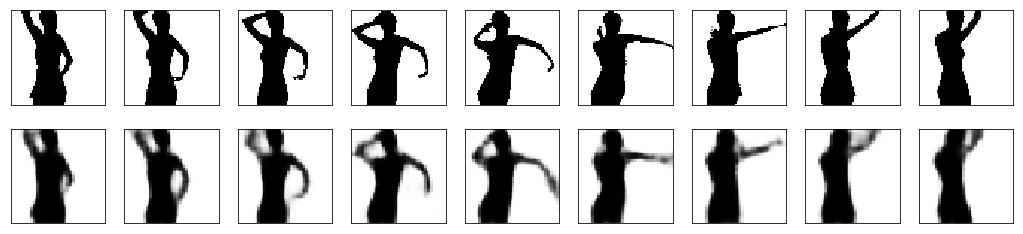

In [42]:
#decoded_imgs = autoencoder.predict(x_test)
import matplotlib.pyplot as plt
%matplotlib inline
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()